In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error
import os

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
wh_df = pd.read_csv('data_qty_vse.csv', sep=',', names=['Date', 'Incomings'], index_col=[0], parse_dates=[0])
wh_df.head()

,Incomings
Date,
2016-01-11,276
2016-01-12,18176
2016-01-13,8284
2016-01-14,59368
2016-01-15,17865


In [102]:
wh_df.shape

(1443, 2)

In [15]:
# проверим пропуски
wh_df['Incomings'].isnull().sum()

0

Text(0, 0.5, 'm3')

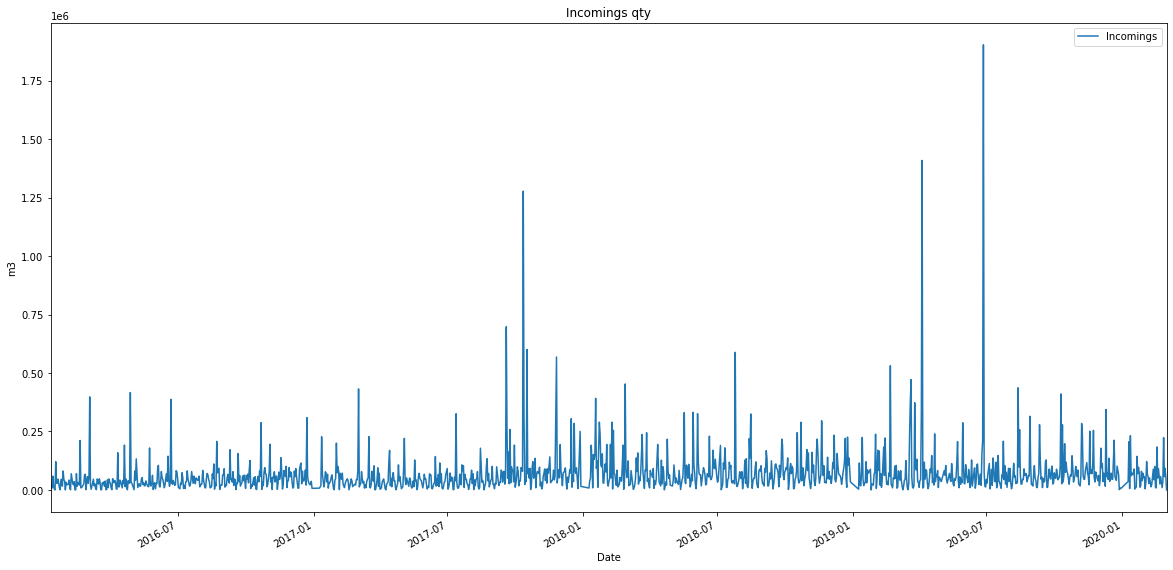

In [3]:
wh_df.plot(figsize = (20, 10), title = 'Incomings qty')
plt.ylabel ('m3')

Выделим тренд и циклы.
1) Тренд:
    - перписывем модель в точки с координатами х1=i-номер измерения, y=значению потребления
    - строим модель y = w1*x1+w0

68698.34372834372 117865.75213419259


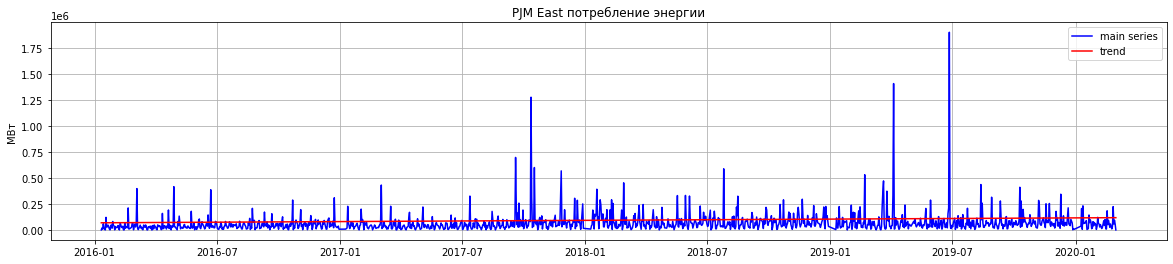

In [20]:
from sklearn.linear_model import LinearRegression

y= wh_df['Incomings'].values
x1 = np.array(range(wh_df.shape[0]))

Lin_mod = LinearRegression()
Lin_mod.fit(x1.reshape(-1, 1),y.reshape(-1, 1))

W1 =Lin_mod.coef_[0,0]
W0 =y.mean()
print(W0,W0+W1*x1[-1])

plt.figure(figsize =(20,4))
plt.plot(wh_df.index, wh_df['Incomings'], 'b' , label ='main series')
plt.plot(wh_df.index[[0,-1]], [W0+W1*x1[0] , W0+W1*x1[-1]], 'r',label='trend')
plt.title('Incomings qty')
plt.legend()
plt.grid()
plt.ylabel ('м3')
plt.show()

Убираем тренд и переходим к поиску циклов.

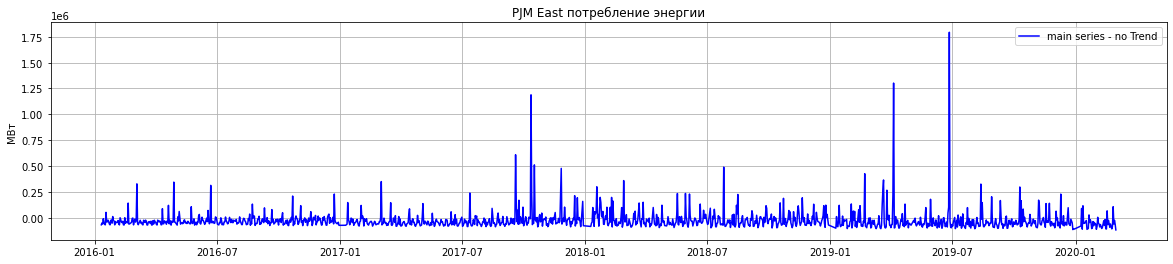

In [21]:
y_no_trend = y - W0-W1*x1

plt.figure(figsize =(20,4))
plt.plot(wh_df.index, y_no_trend, 'b' , label ='main series - no Trend')

plt.title('Incomings qty')
plt.legend()
plt.grid()
plt.ylabel ('м3')
plt.show()

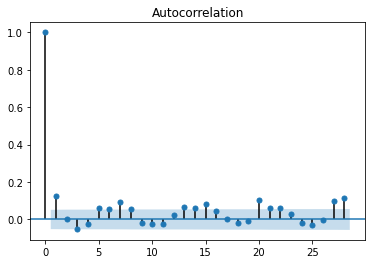

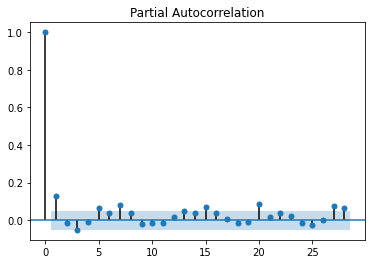

In [25]:
sm.graphics.tsa.plot_acf(wh_df['Incomings'].values, lags=28)
plt.show()

sm.graphics.tsa.plot_pacf(wh_df['Incomings'].values, lags=28)
plt.show()

Получили оценку автокорреляции дневной модели по иcходному ряду. Для этой модели можно увидеть автокорреляцию с лагом 5-8 дней) и корреляцию остатков по первым тем же лагам лагам (Partial Autocorrelation).

In [27]:
delta_range = range(52*5,52*8)
stdi=[]
for delta in delta_range:
    stdi.append(np.std(y_no_trend[delta:]-y_no_trend[:-delta]))
tab_=pd.DataFrame(data=stdi,index=delta_range)
season = np.argmin(tab_[0])
print('длина годового цикла = ',np.argmin(tab_[0])) 

длина годового цикла =  319


In [74]:
tab_

,0
260,139216.832031
261,136343.915131
262,137727.893914
263,137037.730180
264,137904.869696
...,...
411,135785.697941
412,137180.724124
413,137735.053447
414,136156.923023


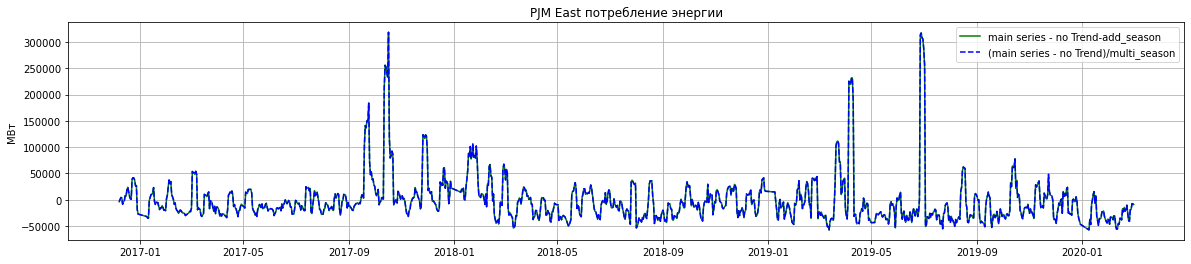

In [46]:
# снимаем составляющую из недельного сдвига (вычитаем среднюю по длине цикла из ACF)
# без тренда
y_no_trend_no_season = pd.DataFrame(data=y_no_trend, index =wh_df.index, columns =['no_trend'])
# тренд
y_no_trend_no_season['trend'] = W0-W1*x1
# сезонные аддитивные сдвиги
y_no_trend_no_season['no_season'] = y_no_trend_no_season['no_trend']-y_no_trend_no_season['no_trend'].rolling(season).mean()

# определяем потенциальную дилну сезонного цикла в днях цикла
delta_range = range(5,9)

#подбор по параметру лучшей средней абсолютной разницы
s_i=[]
for delta in delta_range:
    s_i.append(np.mean((y_no_trend_no_season['no_season']-y_no_trend_no_season['no_season'].rolling(delta).mean())))
tab_f=pd.DataFrame(data=s_i,index=delta_range,columns=['add'])
season_f = np.argmin(np.abs(tab_f['add']))

#подбор для мультипликативной модели (средний индекс должет быть 1)
delta_range = range(5,9)
s_i=[]
for delta in delta_range:
    s_i.append(np.mean(y_no_trend_no_season['no_season']/y_no_trend_no_season['no_season'].rolling(delta).mean()))
tab_f['multi_season']=np.array(s_i)
season_fm = np.argmin(np.abs(tab_f['multi_season']-1))

# порисуем
plt.figure(figsize =(20,4))
plt.plot( wh_df.index,y_no_trend_no_season['no_season'].rolling(season_f).mean(), 'g' , label ='main series - no Trend-add_season')
plt.plot( wh_df.index,y_no_trend_no_season['no_season'].rolling(season_fm).mean(), '--b' , label ='(main series - no Trend)/multi_season')


plt.title('Incomings qty')
plt.legend()
plt.grid()
plt.ylabel ('м3')
plt.show()

Построили тренд и варианты сезонной модели. Однако похоже, что аддитивный сезон не рабочий. Берем мультипликативный сезон и покажем, какие варианты лучшие (среднее частное ближе к 1)

In [52]:
np.abs(tab_f-1)

,add,multi_season
5,66.273309,1.388454
6,61.051011,0.649889
7,90.602912,1.870413
8,99.307298,2.069609


лучший вариант по мультипликативному сезону: 6 дней

Уберем сезонную составляющую

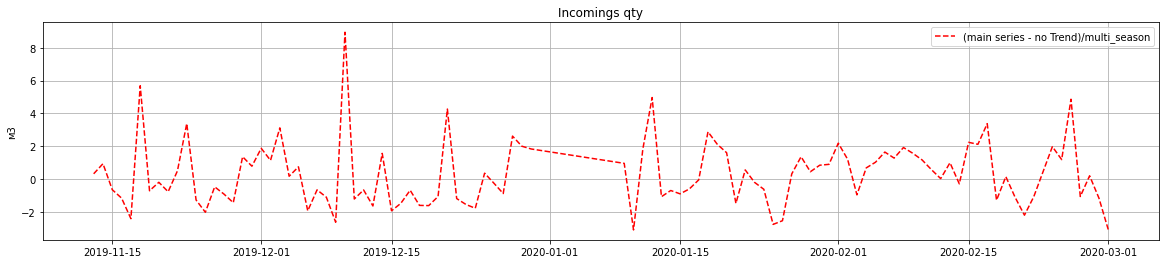

In [78]:
y_season=y_no_trend_no_season['no_season'].rolling(season_fm).mean()
y_season[np.where(np.abs(y_season)<np.mean(np.abs(y_season)))[0]]=np.mean(np.abs(y_season))
# запишем сезонную составляющую
y_no_trend_no_season['season'] = y_season
# сохраним остатки без сезона и тренда
y_no_trend_no_season['no_trend_no_season'] = y_no_trend_no_season['no_season']/y_season

y_no_trend_no_season['add_season'] = y_no_trend_no_season['no_trend'].rolling(season).mean()

plt.figure(figsize =(20,4))

plt.plot(wh_df.index[-100:],y_no_trend_no_season['no_trend_no_season'][-100:] , 
         '--r' , label ='(main series - no Trend)/multi_season')


plt.title('Incomings qty')
plt.legend()
plt.grid()
plt.ylabel ('м3')
plt.show()

In [79]:
y_no_trend_no_season.tail()

,no_trend,trend,no_season,season,no_trend_no_season,add_season
Date,,,,,,
2020-02-26,106481.634574,19667.322031,137225.462194,28199.297522,4.866272,-30743.827620
2020-02-27,-61152.462103,19633.225354,-30140.603637,28199.297522,-1.068842,-31011.858466
2020-02-28,-25373.558780,19599.128677,5494.151849,28199.297522,0.194833,-30867.710629
2020-02-29,-63616.655457,19565.032000,-32779.531537,28199.297522,-1.162424,-30837.123921
2020-03-01,-117784.752134,19530.935322,-86878.725894,28199.297522,-3.080883,-30906.026240


Итак ряд состоит из:
 - тренд y1=y_no_trend_no_season['trend']
 - сезон y2=y_no_trend_no_season['season']
 - остатки y3=y_no_trend_no_season['no_trend_no_season']
 
 Ряд можно собрать назад:
 
 y3*y2+y1

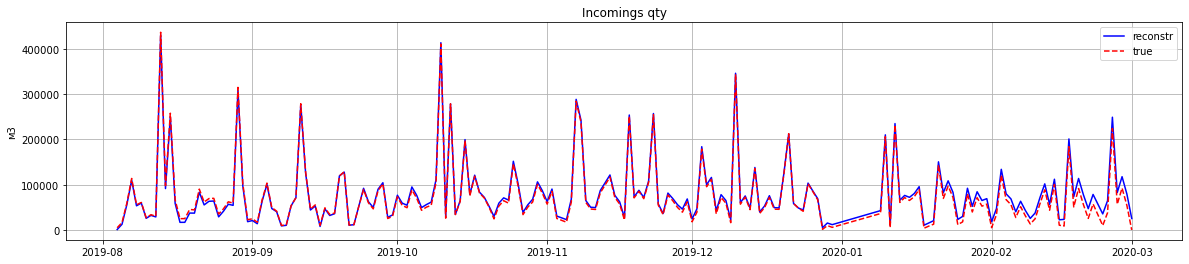

In [98]:
plt.figure(figsize =(20,4))

# 3*y_no_trend_no_season['add_season'][-280:]  - поправка на неаккуратные добавки -сделаные выше (при выделении сезона не учтена)
plt.plot(wh_df.index[-200:],
         y_no_trend_no_season['season'][-200:]*y_no_trend_no_season['no_trend_no_season'][-200:]+y_no_trend_no_season['trend'][-200:]-3*y_no_trend_no_season['add_season'][-200:],
         'b' , label ='reconstr')
plt.plot( wh_df.index[-200:],wh_df['Incomings'].iloc[-200:] , '--r' , label ='true')

plt.title('Incomings qty')
plt.legend()
plt.grid()
plt.ylabel ('м3')
plt.show()

Обратная операция прошла штатно, т.е. собрали ряд обратно и можно строить модели по каждой части отдельно. 

In [171]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

In [124]:
y_no_trend_no_season.dropna(axis=0)

,no_trend,trend,no_season,season,no_trend_no_season,add_season
Date,,,,,,
2016-12-08,11639.429562,57685.117019,40467.966896,28199.297522,1.435070,-28828.537334
2016-12-09,-22278.667115,57651.020342,6417.709843,28199.297522,0.227584,-28696.376958
2016-12-10,-46229.763792,57616.923665,-17603.807399,28199.297522,-0.624264,-28625.956393
2016-12-11,-72730.860469,57582.826987,-43713.688276,28199.297522,-1.550169,-29017.172193
2016-12-12,-71326.957146,57548.730310,-42213.964138,28199.297522,-1.496986,-29112.993008
...,...,...,...,...,...,...
2020-02-26,106481.634574,19667.322031,137225.462194,28199.297522,4.866272,-30743.827620
2020-02-27,-61152.462103,19633.225354,-30140.603637,28199.297522,-1.068842,-31011.858466
2020-02-28,-25373.558780,19599.128677,5494.151849,28199.297522,0.194833,-30867.710629


In [125]:
# сделаем примеры и модель 
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train, test = split_data(y_no_trend_no_season, '2019-03-01')

In [156]:
X_train_trend = train
y_train_trend = train['trend'].values
X_test_trend = test
y_test_trend = test['trend'].values

X_train_season = train
y_train_season = train['season'].values
X_test_season = test
y_test_season = test['season'].values

X_train_no_trend_no_season = train
y_train_no_trend_no_season = train['no_trend_no_season'].values
X_test_no_trend_no_season = test
y_test_no_trend_no_season = test['no_trend_no_season'].values

X_train_add_season = train
y_train_add_season = train['add_season'].values
X_test_add_season = test
y_test_add_season = test['add_season'].values

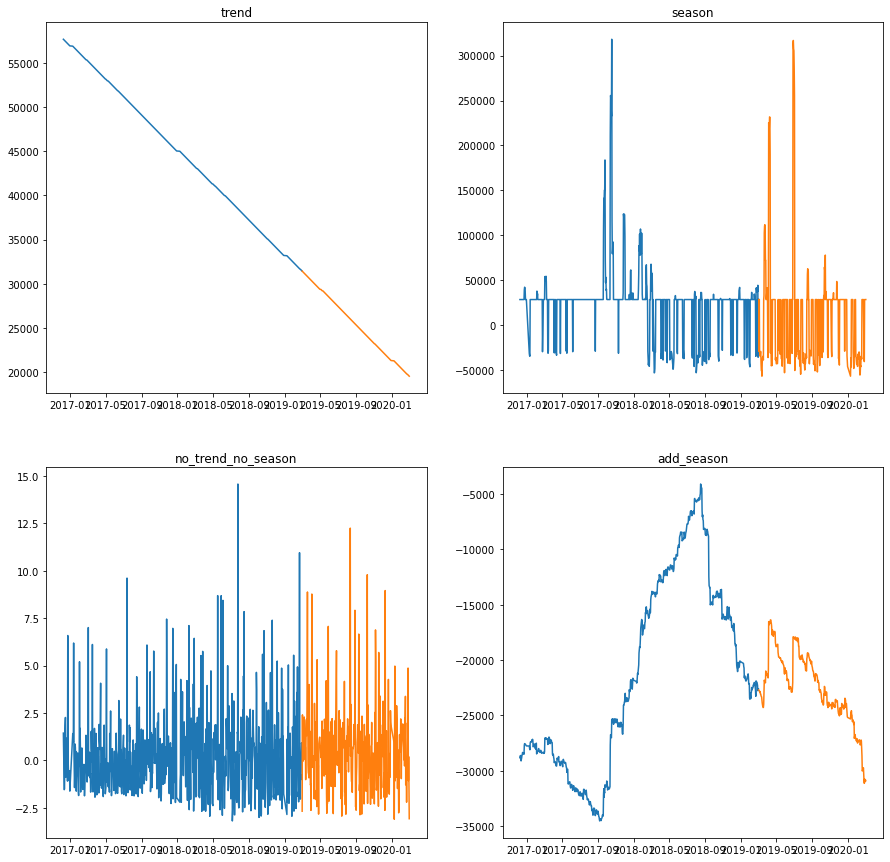

In [180]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(train.index.get_level_values('Date'),train['trend'], label='train data')
plt.plot(test.index.get_level_values('Date'),test['trend'], label='test data')
plt.title('trend')

plt.subplot(2, 2, 2)
plt.plot(train.index.get_level_values('Date'),train['season'], label='train data')
plt.plot(test.index.get_level_values('Date'),test['season'], label='test data')
plt.title('season')

plt.subplot(2, 2, 3)
plt.plot(train.index.get_level_values('Date'),train['no_trend_no_season'], label='train data')
plt.plot(test.index.get_level_values('Date'),test['no_trend_no_season'], label='test data')
plt.title('no_trend_no_season')

plt.subplot(2, 2, 4)
plt.plot(train.index.get_level_values('Date'),train['add_season'], label='train data')
plt.plot(test.index.get_level_values('Date'),test['add_season'], label='test data')
plt.title('add_season')

plt.show()

In [158]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

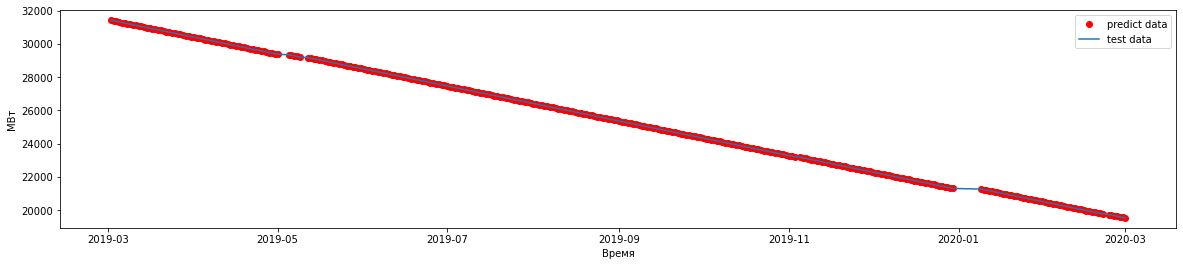

ошибка градиентного бустинга :   7.940490942883472e-14 %


In [194]:
model_trend = LinearRegression()
model_trend.fit(X_train_trend, y_train_trend) 
y_test_pred_trend = model_trend.predict(X_test_trend)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(test.index.get_level_values('Date'),y_test_pred_trend, 'or',label='predict data' )
plt.plot(test.index.get_level_values('Date'),y_test_trend, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_trend, y_pred=y_test_pred_trend)

print('ошибка градиентного бустинга :  ', er_g, '%')

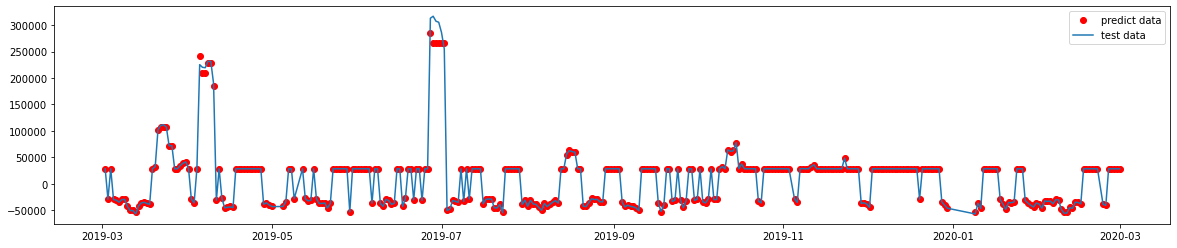

ошибка градиентного бустинга :   0.9224855354910286 %


In [212]:
model_season = GradientBoostingRegressor(min_samples_split=10, min_samples_leaf=3, max_depth=15, loss='ls',
                                         random_state=42, n_estimators=500, learning_rate=0.01)
model_season.fit(X_train_season, y_train_season) 
y_test_pred_season = model_season.predict(X_test_season)

plt.figure( figsize=( 20, 4 ))

plt.plot(test.index.get_level_values('Date'),y_test_pred_season, 'or', label='predict data' )
plt.plot(test.index.get_level_values('Date'),y_test_season, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_season, y_pred=y_test_pred_season)

print('ошибка градиентного бустинга :  ', er_g, '%')

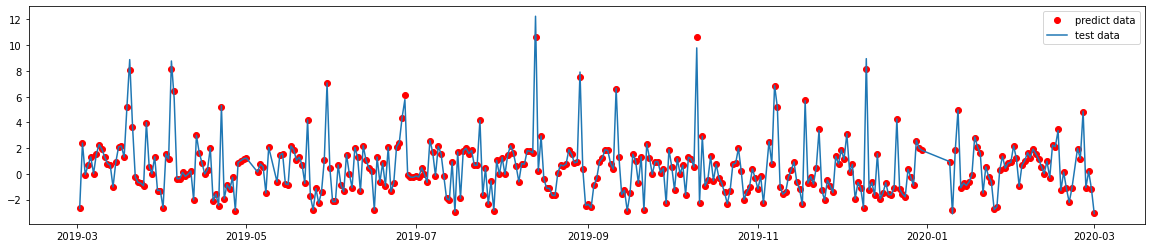

ошибка градиентного бустинга :   1.6778857472053912 %


In [211]:
model_no_trend_no_season = GradientBoostingRegressor(min_samples_split=10, min_samples_leaf=3, max_depth=15, loss='ls',
                                         random_state=42, n_estimators=500, learning_rate=0.01)
model_no_trend_no_season.fit(X_train_no_trend_no_season, y_train_no_trend_no_season) 
y_test_pred_no_trend_no_season = model_no_trend_no_season.predict(X_test_no_trend_no_season)

plt.figure( figsize=( 20, 4 ))

plt.plot(test.index.get_level_values('Date'),y_test_pred_no_trend_no_season, 'or',label='predict data' )
plt.plot(test.index.get_level_values('Date'),y_test_no_trend_no_season, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_no_trend_no_season, y_pred=y_test_pred_no_trend_no_season)

print('ошибка градиентного бустинга :  ', er_g, '%')

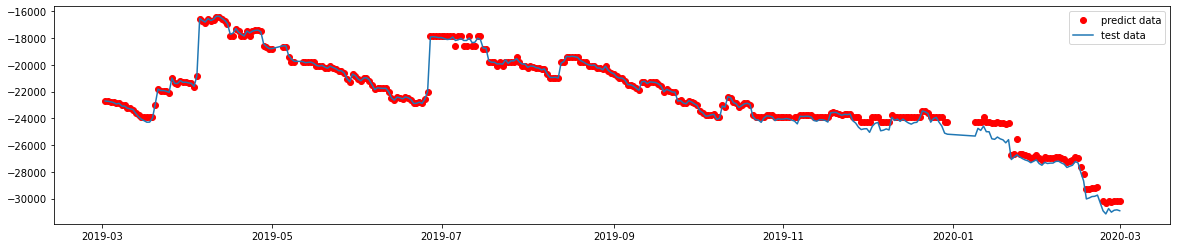

ошибка градиентного бустинга :   0.7499621596595315 %


In [214]:
model_add_season = GradientBoostingRegressor(min_samples_split=10, min_samples_leaf=3, max_depth=15, loss='ls',
                                         random_state=42, n_estimators=500, learning_rate=0.01)
model_add_season.fit(X_train_add_season, y_train_add_season) 
y_test_pred_add_season = model_add_season.predict(X_test_add_season)

plt.figure( figsize=( 20, 4 ))

plt.plot(test.index.get_level_values('Date'),y_test_pred_add_season, 'or',label='predict data' )
plt.plot(test.index.get_level_values('Date'),y_test_add_season, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_add_season, y_pred=y_test_pred_add_season)

print('ошибка градиентного бустинга :  ', er_g, '%')

Теперь соберем нашу модель обратно и проверим качетсво предсказания.

In [215]:
reconstr = y_test_pred_season*y_test_pred_no_trend_no_season+y_test_pred_trend-3*y_test_pred_add_season

In [220]:
reconstr_df = pd.DataFrame(data = reconstr, index=test.index, columns=['Incomings_pred'])
reconstr_df.head()

,Incomings_pred
Date,
2019-03-02,23850.956098
2019-03-03,29712.627196
2019-03-04,98020.361560
2019-03-05,80041.172703
2019-03-06,59585.549765


In [221]:
train_wf, test_wf = split_data(wh_df, '2019-03-01')

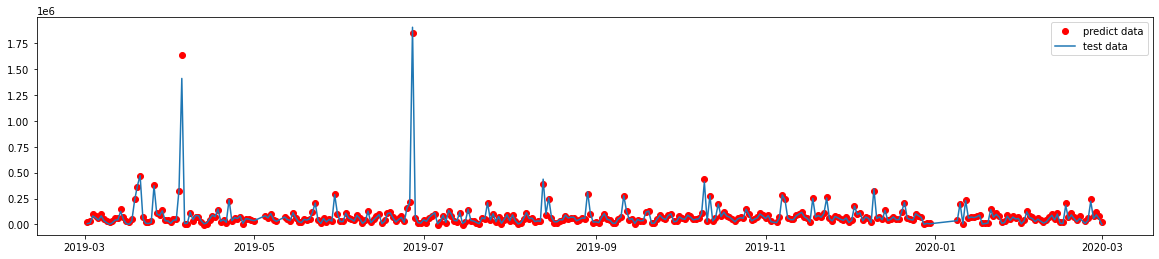

ошибка градиентного бустинга :   121.26665878941682 %


In [224]:
plt.figure( figsize=( 20, 4 ))

plt.plot(reconstr_df.index.get_level_values('Date'),reconstr_df['Incomings_pred'], 'or',label='predict data' )
plt.plot(test_wf.index.get_level_values('Date'),test_wf['Incomings'], label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=test_wf['Incomings'], y_pred=reconstr_df['Incomings_pred'])

print('ошибка градиентного бустинга :  ', er_g, '%')

In [225]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
er_s = mean_squared_error(y_true=test_wf['Incomings'], y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=test_wf['Incomings'], y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, test_wf['Incomings']=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)